In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import unicodedata

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2025-12-03 12:29:43.903187: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-03 12:29:43.903485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 12:29:43.939835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 12:29:44.885385: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
# Ruta base de los datasets
DATA_DIR = Path("../datasets")  # cámbialo si están en otra carpeta

# Cargar ventas y eventos
df_ventas = pd.read_csv(DATA_DIR / "ventas_completo_con_frutas_verduras.csv")
df_eventos = pd.read_csv(DATA_DIR / "eventos_productos.csv")

print(df_ventas.head())
print(df_ventas.info())
print(df_eventos.head())
print(df_eventos.info())

        fecha           product_name category_off  perecedero  ventas  precio  \
0  2022-12-01  Néctar de durazno 1 L    juice-box           0      10   33.72   
1  2022-12-02  Néctar de durazno 1 L    juice-box           0       5   33.66   
2  2022-12-03  Néctar de durazno 1 L    juice-box           0       7   31.48   
3  2022-12-04  Néctar de durazno 1 L    juice-box           0      11   32.30   
4  2022-12-05  Néctar de durazno 1 L    juice-box           0       8   33.01   

   en_promocion  en_temporada  temp_inicio_mes  temp_fin_mes  
0             0             0              7.0           9.0  
1             0             0              7.0           9.0  
2             0             0              7.0           9.0  
3             0             0              7.0           9.0  
4             0             0              7.0           9.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299208 entries, 0 to 299207
Data columns (total 10 columns):
 #   Column           No

In [3]:
def normalize_text(texto: str) -> str:
    """
    Deja el texto en minúsculas, sin acentos y sin espacios duplicados.
    Sirve para hacer joins robustos entre nombres de productos.
    """
    if pd.isna(texto):
        return ""
    texto = str(texto).lower().strip()
    texto = unicodedata.normalize("NFD", texto)
    texto = "".join(c for c in texto if unicodedata.category(c) != "Mn")
    texto = " ".join(texto.split())
    return texto

# Asegurar tipos de fecha
df_ventas["fecha"] = pd.to_datetime(df_ventas["fecha"])
df_eventos["date"] = pd.to_datetime(df_eventos["date"])

# Claves normalizadas de producto
df_ventas["product_key"] = df_ventas["product_name"].apply(normalize_text)
df_eventos["product_key"] = df_eventos["producto_relacionado"].apply(normalize_text)

# Hacemos un merge left para marcar eventos por (fecha, producto)
df_eventos_reduc = df_eventos[["event", "date", "product_key"]].drop_duplicates()

df_ventas_evt = df_ventas.merge(
    df_eventos_reduc,
    left_on=["fecha", "product_key"],
    right_on=["date", "product_key"],
    how="left"
)

# hay_evento = 1 si existe un evento para ese producto en esa fecha
df_ventas_evt["hay_evento"] = df_ventas_evt["event"].notna().astype(int)

# Ya no necesitamos la columna date del merge
df_ventas_evt = df_ventas_evt.drop(columns=["date"])

df_ventas_evt.head(10)


,fecha,product_name,category_off,perecedero,ventas,precio,en_promocion,en_temporada,temp_inicio_mes,temp_fin_mes,product_key,event,hay_evento
0,2022-12-01,Néctar de durazno 1 L,juice-box,0,10,33.72,0,0,7.0,9.0,nectar de durazno 1 l,NaN,0
1,2022-12-02,Néctar de durazno 1 L,juice-box,0,5,33.66,0,0,7.0,9.0,nectar de durazno 1 l,NaN,0
2,2022-12-03,Néctar de durazno 1 L,juice-box,0,7,31.48,0,0,7.0,9.0,nectar de durazno 1 l,NaN,0
3,2022-12-04,Néctar de durazno 1 L,juice-box,0,11,32.30,0,0,7.0,9.0,nectar de durazno 1 l,NaN,0
4,2022-12-05,Néctar de durazno 1 L,juice-box,0,8,33.01,0,0,7.0,9.0,nectar de durazno 1 l,NaN,0
5,2022-12-06,Néctar de durazno 1 L,juice-box,0,2,31.45,0,0,7.0,9.0,nectar de durazno 1 l,NaN,0
6,2022-12-07,Néctar de durazno 1 L,juice-box,0,4,33.37,0,0,7.0,9.0,nectar de durazno 1 l,NaN,0
7,2022-12-08,Néctar de durazno 1 L,juice-box,0,9,31.81,0,0,7.0,9.0,nectar de durazno 1 l,NaN,0
8,2022-12-09,Néctar de durazno 1 L,juice-box,0,9,31.24,0,0,7.0,9.0,nectar de durazno 1 l,NaN,0
9,2022-12-10,Néctar de durazno 1 L,juice-box,0,6,29.44,0,0,7.0,9.0,nectar de durazno 1 l,NaN,0


In [4]:
ventas = df_ventas_evt.copy()

# Calendario
ventas["anio"] = ventas["fecha"].dt.year
ventas["mes"] = ventas["fecha"].dt.month
ventas["dia"] = ventas["fecha"].dt.day
ventas["dia_semana"] = ventas["fecha"].dt.weekday
ventas["es_fin_semana"] = ventas["dia_semana"].isin([5, 6]).astype(int)

# Codificación cíclica de mes y día de semana
ventas["mes_sin"] = np.sin(2 * np.pi * ventas["mes"] / 12)
ventas["mes_cos"] = np.cos(2 * np.pi * ventas["mes"] / 12)
ventas["dow_sin"] = np.sin(2 * np.pi * ventas["dia_semana"] / 7)
ventas["dow_cos"] = np.cos(2 * np.pi * ventas["dia_semana"] / 7)

# Booleanos a 0/1
ventas["en_promocion"] = ventas["en_promocion"].astype(int)
ventas["en_temporada"] = ventas["en_temporada"].astype(int)

# IDs de producto y categoría
ventas["product_id"], _ = pd.factorize(ventas["product_name"])
ventas["category_id"], _ = pd.factorize(ventas["category_off"])

ventas.head()


,fecha,product_name,category_off,perecedero,ventas,precio,en_promocion,en_temporada,temp_inicio_mes,temp_fin_mes,...,mes,dia,dia_semana,es_fin_semana,mes_sin,mes_cos,dow_sin,dow_cos,product_id,category_id
0,2022-12-01,Néctar de durazno 1 L,juice-box,0,10,33.72,0,0,7.0,9.0,...,12,1,3,0,-2.449294e-16,1.0,0.433884,-0.900969,0,0
1,2022-12-02,Néctar de durazno 1 L,juice-box,0,5,33.66,0,0,7.0,9.0,...,12,2,4,0,-2.449294e-16,1.0,-0.433884,-0.900969,0,0
2,2022-12-03,Néctar de durazno 1 L,juice-box,0,7,31.48,0,0,7.0,9.0,...,12,3,5,1,-2.449294e-16,1.0,-0.974928,-0.222521,0,0
3,2022-12-04,Néctar de durazno 1 L,juice-box,0,11,32.30,0,0,7.0,9.0,...,12,4,6,1,-2.449294e-16,1.0,-0.781831,0.623490,0,0
4,2022-12-05,Néctar de durazno 1 L,juice-box,0,8,33.01,0,0,7.0,9.0,...,12,5,0,0,-2.449294e-16,1.0,0.000000,1.000000,0,0


In [5]:
ventas = ventas.sort_values(["product_id", "fecha"])

def crear_ventanas(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    g = df.groupby("product_id")["ventas"]
    df["lag_1"] = g.shift(1)
    df["lag_7"] = g.shift(7)
    df["lag_14"] = g.shift(14)
    df["media_7"] = g.shift(1).rolling(7).mean()
    df["media_28"] = g.shift(1).rolling(28).mean()
    df["media_90"] = g.shift(1).rolling(90).mean()
    return df

ventas = crear_ventanas(ventas)

# Eliminamos filas sin historial suficiente
ventas_modelo = ventas.dropna(subset=[
    "lag_1", "lag_7", "lag_14",
    "media_7", "media_28", "media_90"
])

ventas_modelo.head()


,fecha,product_name,category_off,perecedero,ventas,precio,en_promocion,en_temporada,temp_inicio_mes,temp_fin_mes,...,dow_sin,dow_cos,product_id,category_id,lag_1,lag_7,lag_14,media_7,media_28,media_90
45,2023-01-15,Néctar de durazno 1 L,juice-box,0,8,31.92,0,0,7.0,9.0,...,-0.781831,0.62349,0,0,11.0,9.0,6.0,8.285714,6.535714,6.800000
187461,2023-01-15,Néctar de durazno 1 L,juice-box,0,7,42.08,0,0,7.0,9.0,...,-0.781831,0.62349,0,0,8.0,9.0,7.0,8.142857,6.750000,6.777778
46,2023-01-16,Néctar de durazno 1 L,juice-box,0,7,33.93,0,0,7.0,9.0,...,0.000000,1.00000,0,0,7.0,8.0,7.0,7.857143,6.678571,6.800000
187462,2023-01-16,Néctar de durazno 1 L,juice-box,0,6,39.90,0,0,7.0,9.0,...,0.000000,1.00000,0,0,7.0,11.0,2.0,7.714286,6.785714,6.822222
47,2023-01-17,Néctar de durazno 1 L,juice-box,0,4,32.01,0,0,7.0,9.0,...,0.781831,0.62349,0,0,6.0,2.0,5.0,7.000000,6.928571,6.811111


In [6]:
# Features para el modelo
features = [
    "product_id", "category_id", "perecedero",
    "precio", "en_promocion", "en_temporada", "hay_evento",
    "anio", "mes", "dia_semana", "es_fin_semana",
    "mes_sin", "mes_cos", "dow_sin", "dow_cos",
    "lag_1", "lag_7", "lag_14", "media_7", "media_28", "media_90"
]

X = ventas_modelo[features]
y = ventas_modelo["ventas"]

# Corte temporal (puedes ajustar la fecha si quieres)
fecha_corte = pd.to_datetime("2025-06-01")

mask_train = ventas_modelo["fecha"] < fecha_corte
mask_test = ventas_modelo["fecha"] >= fecha_corte

X_train = X[mask_train]
X_test = X[mask_test]
y_train = y[mask_train]
y_test = y[mask_test]

X_train.shape, X_test.shape


((236289, 21), (49959, 21))

In [7]:
# Copias para NN
X_train_nn = X_train.copy()
X_test_nn = X_test.copy()
y_train_nn = y_train.astype("float32").copy()
y_test_nn = y_test.astype("float32").copy()

# Asegurar que todo sea numérico
for col in X_train_nn.columns:
    X_train_nn[col] = pd.to_numeric(X_train_nn[col], errors="coerce")
    X_test_nn[col] = pd.to_numeric(X_test_nn[col], errors="coerce")

# Convertir a float32
X_train_nn = X_train_nn.astype("float32")
X_test_nn = X_test_nn.astype("float32")

# Filtrar filas con NaN o infinitos
mask_train_clean = np.isfinite(X_train_nn.to_numpy()).all(axis=1) & np.isfinite(y_train_nn.to_numpy())
mask_test_clean = np.isfinite(X_test_nn.to_numpy()).all(axis=1) & np.isfinite(y_test_nn.to_numpy())

X_train_nn = X_train_nn[mask_train_clean]
y_train_nn = y_train_nn[mask_train_clean]
X_test_nn = X_test_nn[mask_test_clean]
y_test_nn = y_test_nn[mask_test_clean]

print("Shapes limpias:", X_train_nn.shape, X_test_nn.shape)


Shapes limpias: (236289, 21) (49959, 21)


In [8]:
# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nn)
X_test_scaled = scaler.transform(X_test_nn)

X_train_scaled.shape, X_test_scaled.shape


((236289, 21), (49959, 21))

In [9]:
def big_error_loss(y_true, y_pred):
    """
    Penaliza más fuerte los errores grandes.
    - Umbral configurable (threshold)
    - Si el error absoluto > threshold, se multiplica la penalización.
    """
    err = tf.abs(y_true - y_pred)
    mse = tf.square(err)
    
    threshold = 5.0     # puedes tunear este valor
    factor_grande = 5.0 # cuánto más castigar los errores grandes
    
    weights = tf.where(err > threshold, factor_grande, 1.0)
    weighted_mse = mse * weights
    return tf.reduce_mean(weighted_mse)

input_dim = X_train_scaled.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1)   # regresión
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=big_error_loss,
    metrics=["mae"]
)

model.summary()

2025-12-03 12:29:46.233198: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train_nn,
    validation_data=(X_test_scaled, y_test_nn),
    epochs=200,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1119.3374 - mae: 6.5860 - val_loss: 449.4015 - val_mae: 5.3383
Epoch 2/200
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 448.1813 - mae: 5.1144 - val_loss: 429.6049 - val_mae: 5.2306
Epoch 3/200
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 434.3101 - mae: 5.0369 - val_loss: 422.0508 - val_mae: 5.3148
Epoch 4/200
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 424.2596 - mae: 4.9821 - val_loss: 405.8274 - val_mae: 5.1291
Epoch 5/200
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 414.5602 - mae: 4.9259 - val_loss: 405.3613 - val_mae: 5.0763
Epoch 6/200
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 412.5811 - mae: 4.8981 - val_loss: 399.9861 - val_mae: 5.0364
Epoch 7/200
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 404.8584 - mae: 4.8626 - val_loss: 392.4873 - val_mae: 5.0336
Epoch 8/200
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 405.9254 - mae: 4.8363 - val_loss: 394.3123 - val_mae: 4.9505
Epoch 9/200
231

In [11]:
# Predicciones
y_pred_nn = model.predict(X_test_scaled).ravel()

mae_nn = mean_absolute_error(y_test_nn, y_pred_nn)
mape_nn = mean_absolute_percentage_error(y_test_nn, y_pred_nn)

print("Neural Network MAE:", mae_nn)
print("Neural Network MAPE:", mape_nn)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 336us/step
Neural Network MAE: 4.60714054107666
Neural Network MAPE: 715826361532416.0


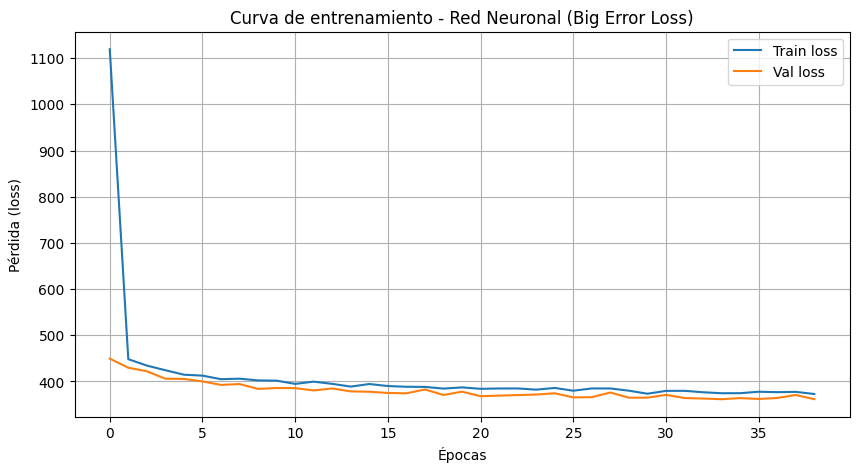

In [12]:
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (loss)")
plt.title("Curva de entrenamiento - Red Neuronal (Big Error Loss)")
plt.legend()
plt.grid(True)
plt.show()


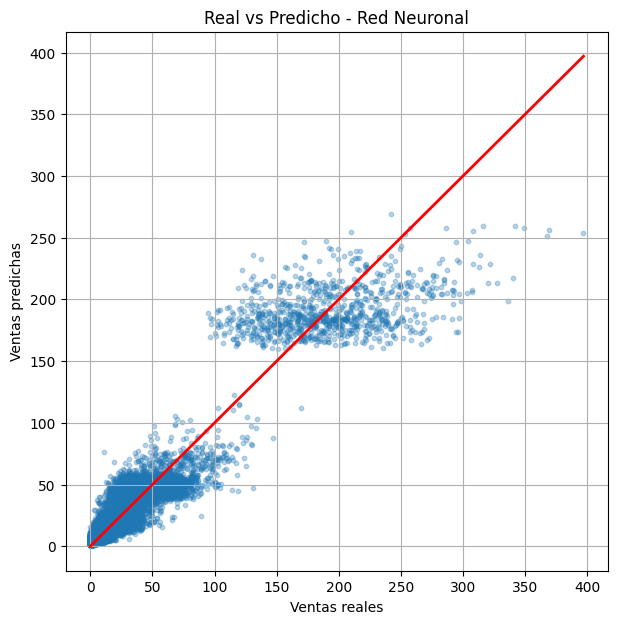

In [13]:
plt.figure(figsize=(7,7))
plt.scatter(y_test_nn, y_pred_nn, alpha=0.3, s=10)
max_val = max(y_test_nn.max(), y_pred_nn.max())
plt.plot([0, max_val], [0, max_val], color="red", linewidth=2)
plt.xlabel("Ventas reales")
plt.ylabel("Ventas predichas")
plt.title("Real vs Predicho - Red Neuronal")
plt.grid(True)
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


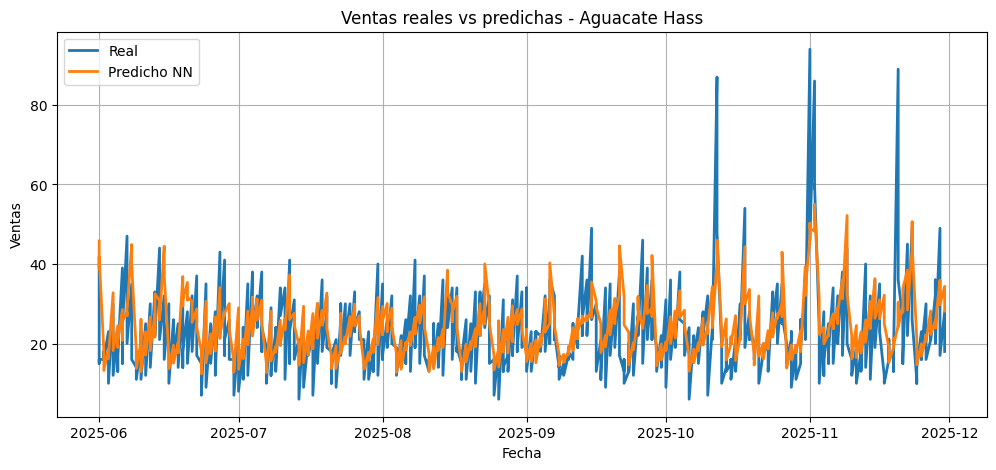

In [14]:
nombre_producto = "Aguacate Hass"  # cámbialo por el producto que quieras analizar

# Obtenemos el product_id correspondiente
pid = ventas_modelo.loc[
    ventas_modelo["product_name"] == nombre_producto, "product_id"
].iloc[0]

# Creamos máscara de test solo para ese producto
mask_prod_test = (ventas_modelo["product_id"] == pid) & (ventas_modelo["fecha"] >= fecha_corte)

# Alinear índices con X_test_nn / y_test_nn
indices_test = X_test_nn.index
indices_prod_test = indices_test[mask_prod_test.loc[indices_test]]

fechas_prod = ventas_modelo.loc[indices_prod_test, "fecha"]
y_real_prod = y_test_nn.loc[indices_prod_test]
X_prod_scaled = X_test_scaled[indices_test.get_indexer(indices_prod_test)]
y_pred_prod = model.predict(X_prod_scaled).ravel()

plt.figure(figsize=(12,5))
plt.plot(fechas_prod, y_real_prod, label="Real", linewidth=2)
plt.plot(fechas_prod, y_pred_prod, label="Predicho NN", linewidth=2)
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.title(f"Ventas reales vs predichas - {nombre_producto}")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Nos aseguramos de que df_eventos tenga clave normalizada
df_eventos["product_key"] = df_eventos["producto_relacionado"].apply(normalize_text)
df_eventos["date"] = pd.to_datetime(df_eventos["date"])

def hay_evento_en_fecha(nombre_producto: str, fecha: pd.Timestamp) -> int:
    """
    Regresa 1 si ese producto tiene un evento exactamente en esa fecha, 0 en caso contrario.
    """
    pkey = normalize_text(nombre_producto)
    eventos_prod = df_eventos[df_eventos["product_key"] == pkey]
    if eventos_prod.empty:
        return 0
    return int(fecha.normalize() in eventos_prod["date"].dt.normalize().values)


In [16]:
from datetime import timedelta, datetime

def predecir_proximos_dias(nombre_producto: str, dias: int = 7) -> pd.DataFrame:
    """
    Predice las ventas de los próximos 'dias' días para un producto específico
    usando el modelo de red neuronal entrenado.
    
    Usa:
      - ventas_modelo (histórico con lags ya calculados)
      - model (red neuronal)
      - scaler (StandardScaler)
      - features (lista de columnas de entrada)
      - df_eventos (para hay_evento)
    """
    # 1. Obtener el product_id y el histórico de ese producto
    df_prod_hist = ventas_modelo[ventas_modelo["product_name"] == nombre_producto].copy()
    if df_prod_hist.empty:
        raise ValueError(f"No se encontró histórico para el producto: {nombre_producto}")
    
    df_prod_hist = df_prod_hist.sort_values("fecha")
    
    # Información estática del producto (tomamos la última fila)
    last_row = df_prod_hist.iloc[-1]
    product_id = int(last_row["product_id"])
    category_id = int(last_row["category_id"])
    perecedero = int(last_row["perecedero"])
    precio_ultimo = float(last_row["precio"])
    
    # Para lags y medias necesitamos la serie histórica de ventas
    hist_fechas = list(df_prod_hist["fecha"])
    hist_ventas = list(df_prod_hist["ventas"].astype(float))
    
    # 2. Fecha inicial para predicciones: día siguiente del último dato
    fecha_actual = df_prod_hist["fecha"].max()
    

    # Lista donde vamos acumulando resultados
    pred_rows = []
    
    for i in range(dias):
        fecha_pred = fecha_actual + timedelta(days=1)
        
        # --- Calendario ---
        anio = fecha_pred.year
        mes = fecha_pred.month
        dia_semana = fecha_pred.weekday()   # 0 lunes, 6 domingo
        es_fin_semana = 1 if dia_semana in [5, 6] else 0
        
        mes_sin = np.sin(2 * np.pi * mes / 12)
        mes_cos = np.cos(2 * np.pi * mes / 12)
        dow_sin = np.sin(2 * np.pi * dia_semana / 7)
        dow_cos = np.cos(2 * np.pi * dia_semana / 7)
        
        # --- Eventos y flags ---
        hay_evento = hay_evento_en_fecha(nombre_producto, fecha_pred)
        
        # Para simplificar: asumimos mismo patrón de promo y temporada que el último día
        en_promocion = int(last_row["en_promocion"])
        en_temporada = int(last_row["en_temporada"])
        
        # --- Lags y medias basados en hist_ventas (que vamos actualizando) ---
        # Si el histórico es corto, usamos lo que haya
        lag_1 = hist_ventas[-1]
        lag_7 = hist_ventas[-7] if len(hist_ventas) >= 7 else hist_ventas[0]
        lag_14 = hist_ventas[-14] if len(hist_ventas) >= 14 else hist_ventas[0]
        
        media_7 = float(np.mean(hist_ventas[-7:])) if len(hist_ventas) >= 2 else hist_ventas[-1]
        media_28 = float(np.mean(hist_ventas[-28:])) if len(hist_ventas) >= 2 else hist_ventas[-1]
        media_90 = float(np.mean(hist_ventas[-90:])) if len(hist_ventas) >= 2 else hist_ventas[-1]
        
        # --- Armar vector de features en el mismo orden que 'features' ---
        feature_dict = {
            "product_id": product_id,
            "category_id": category_id,
            "perecedero": perecedero,
            "precio": precio_ultimo,          # podrías dinamizar esto futuramente
            "en_promocion": en_promocion,
            "en_temporada": en_temporada,
            "hay_evento": hay_evento,
            "anio": anio,
            "mes": mes,
            "dia_semana": dia_semana,
            "es_fin_semana": es_fin_semana,
            "mes_sin": mes_sin,
            "mes_cos": mes_cos,
            "dow_sin": dow_sin,
            "dow_cos": dow_cos,
            "lag_1": lag_1,
            "lag_7": lag_7,
            "lag_14": lag_14,
            "media_7": media_7,
            "media_28": media_28,
            "media_90": media_90,
        }
        
        # Convertir a DataFrame para pasar por el scaler
        X_fut = pd.DataFrame([feature_dict])[features].astype("float32")
        X_fut_scaled = scaler.transform(X_fut)
        
        # Predicción con el modelo
        y_pred = float(model.predict(X_fut_scaled, verbose=0).ravel()[0])
        
        # Guardar resultado
        pred_rows.append({
            "fecha": fecha_pred,
            "product_name": nombre_producto,
            "prediccion_ventas": max(y_pred, 0.0),  # evitar negativos
            "hay_evento": hay_evento,
            "en_promocion": en_promocion,
            "en_temporada": en_temporada
        })
        
        # Actualizar histórico para el siguiente día (usamos la predicción como nueva venta)
        hist_fechas.append(fecha_pred)
        hist_ventas.append(max(y_pred, 0.0))
        
        # Avanzar fecha
        fecha_actual = fecha_pred
    
    df_pred = pd.DataFrame(pred_rows)
    return df_pred


       fecha   product_name  prediccion_ventas  hay_evento  en_promocion  \
0 2025-12-01  Aguacate Hass          16.186272           0             0   
1 2025-12-02  Aguacate Hass          19.857494           0             0   
2 2025-12-03  Aguacate Hass          20.322178           0             0   
3 2025-12-04  Aguacate Hass          23.036760           0             0   
4 2025-12-05  Aguacate Hass          22.304014           0             0   
5 2025-12-06  Aguacate Hass          25.446632           0             0   
6 2025-12-07  Aguacate Hass          25.560268           0             0   

   en_temporada  
0             1  
1             1  
2             1  
3             1  
4             1  
5             1  
6             1  


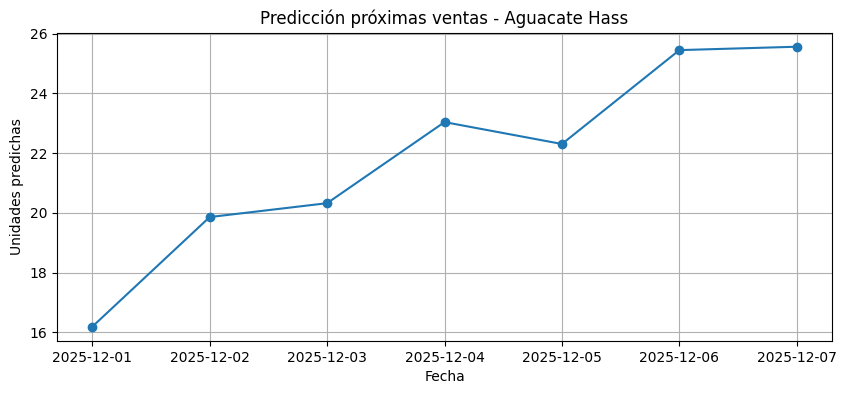

In [17]:
nombre_producto = "Aguacate Hass"  # cámbialo a uno que exista en tu dataset

df_pred_semana = predecir_proximos_dias(nombre_producto, dias=7)
print(df_pred_semana)

plt.figure(figsize=(10,4))
plt.plot(df_pred_semana["fecha"], df_pred_semana["prediccion_ventas"], marker="o")
plt.title(f"Predicción próximas ventas - {nombre_producto}")
plt.xlabel("Fecha")
plt.ylabel("Unidades predichas")
plt.grid(True)
plt.show()


        fecha   product_name  prediccion_ventas  hay_evento  en_promocion  \
0  2025-12-01  Aguacate Hass          16.186272           0             0   
1  2025-12-02  Aguacate Hass          19.857494           0             0   
2  2025-12-03  Aguacate Hass          20.322178           0             0   
3  2025-12-04  Aguacate Hass          23.036760           0             0   
4  2025-12-05  Aguacate Hass          22.304014           0             0   
5  2025-12-06  Aguacate Hass          25.446632           0             0   
6  2025-12-07  Aguacate Hass          25.560268           0             0   
7  2025-12-08  Aguacate Hass          26.750111           1             0   
8  2025-12-09  Aguacate Hass          17.815147           0             0   
9  2025-12-10  Aguacate Hass          19.750278           0             0   
10 2025-12-11  Aguacate Hass          22.703121           0             0   
11 2025-12-12  Aguacate Hass          35.419281           1             0   

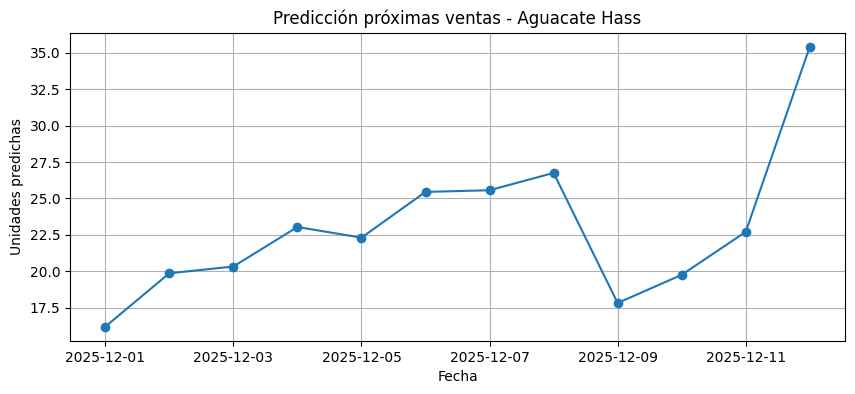

In [18]:
nombre_producto = "Aguacate Hass"  # cámbialo a uno que exista en tu dataset

df_pred_semana = predecir_proximos_dias(nombre_producto, dias=12)
print(df_pred_semana)

plt.figure(figsize=(10,4))
plt.plot(df_pred_semana["fecha"], df_pred_semana["prediccion_ventas"], marker="o")
plt.title(f"Predicción próximas ventas - {nombre_producto}")
plt.xlabel("Fecha")
plt.ylabel("Unidades predichas")
plt.grid(True)
plt.show()


In [19]:
import numpy as np

def sugerir_stock(nombre_producto: str,
                  dias: int = 7,
                  factor_seguridad: float = 1.2):
    """
    Calcula la cantidad de stock sugerido para un producto en un horizonte de 'dias',
    usando el modelo de predicción + un factor de seguridad.

    Parámetros:
    -----------
    nombre_producto : str
        Nombre EXACTO del producto tal como aparece en ventas_modelo["product_name"].
    dias : int, opcional (default=7)
        Número de días a futuro que se quieren cubrir con el stock.
    factor_seguridad : float, opcional (default=1.2)
        Factor multiplicador para protegerte ante errores del modelo y variaciones
        inesperadas en la demanda.
        Ejemplo: 1.2 = 20% extra de colchón.

    Regresa:
    --------
    df_pred : pandas.DataFrame
        Tabla con la predicción diaria:
        [fecha, product_name, prediccion_ventas, hay_evento, en_promocion, en_temporada]
    demanda_esperada : float
        Suma de las unidades esperadas a vender en esos 'dias'.
    stock_sugerido : float
        Unidades recomendadas de stock (demanda_esperada * factor_seguridad).
        Se redondea hacia arriba.
    """
    # 1. Obtener predicciones diarias
    df_pred = predecir_proximos_dias(nombre_producto, dias=dias)

    # 2. Demanda esperada total (suma de las predicciones diarias)
    demanda_esperada = df_pred["prediccion_ventas"].sum()

    # 3. Aplicar factor de seguridad
    stock_sugerido = np.ceil(demanda_esperada * factor_seguridad)

    return df_pred, demanda_esperada, stock_sugerido


In [27]:
producto = "Uva"   # cambia por uno que exista en tu dataset
dias_horizonte = 31
factor_seg = 1.0   # 20% de colchón

df_pred, demanda_esperada, stock_sugerido = sugerir_stock(
    nombre_producto=producto,
    dias=dias_horizonte,
    factor_seguridad=factor_seg
)

print(f"Producto: {producto}")
print(f"Horizonte: {dias_horizonte} días")
print(f"Demanda esperada en {dias_horizonte} días: {demanda_esperada:.2f} unidades")
print(f"Factor de seguridad: {factor_seg}")
print(f"Stock sugerido: {stock_sugerido:.0f} unidades")

print("\nDetalle por día:")
display(df_pred)


Producto: Uva
Horizonte: 31 días
Demanda esperada en 31 días: 2771.37 unidades
Factor de seguridad: 1.0
Stock sugerido: 2772 unidades

Detalle por día:


,fecha,product_name,prediccion_ventas,hay_evento,en_promocion,en_temporada
0,2025-12-01,Uva,64.407280,0,1,1
1,2025-12-02,Uva,63.407501,0,1,1
2,2025-12-03,Uva,66.551018,0,1,1
3,2025-12-04,Uva,69.253464,0,1,1
4,2025-12-05,Uva,71.957863,0,1,1
5,2025-12-06,Uva,86.440506,0,1,1
6,2025-12-07,Uva,90.257889,0,1,1
7,2025-12-08,Uva,73.426842,1,1,1
8,2025-12-09,Uva,71.950714,0,1,1
9,2025-12-10,Uva,74.683929,0,1,1
